In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Intro 

```
This notebook is a minimalistic proof-of-concept showing how a Hailo device can offload the heavy 2D-convolutional part of a point-cloud-input 3D-object-detection network. For this example we use the PointPillars (PP) network from OpenPCDet repo, a modular ecosystem with many 3D networks. The pre/post computation is running in PyTorch using native OpenPCDet code. Almost all of it on CPU, sans the 3D-NMS op which unfortunately is compliled for cuda only. Some of the integration code resides in the openpcdet2hailo_uitls.py. Some integration details, i.e. how we "hook" Hailo into the pytorch model are product of an exploration process of the network as given by OpenPCDet.  See last chapter for an outline of how this has been done, to get a roadmap of how to replicate exploration to other (non-PP) 3D network out of OpenPCdet collection, so that to maximally offload ANY openpcdet 3d-detection net to hailo.
```

## Final result
Processing a point cloud to get 3D boxes - similar result when executing part of network on Hailo. 

We'll go through all steps towards this bottom line in the course of this notebook

In [ ]:
import IPython
IPython.display.Image('./orig_model_front.png', width=300)

In [ ]:
IPython.display.Image('./hailo_assisted_model_front.png', width=300) 

## OpenPCdet - overview


https://github.com/open-mmlab/OpenPCDet


In [ ]:
#<img src="openpcdet_1.png" alt="drawing" height="30%"/>
IPython.display.Image('openpcdet_1.png', width="40%")

In [ ]:
#<img src="openpcdet_1.png" alt="drawing" height="30%"/>
IPython.display.Image('openpcdet_2.png', width="60%")

#### We map to Hailo the 2D backbone and detection head:
```
The purple bracket marks the part of net we can offload to any Hailo device ("Hx" = H8,H15,..). 
In case of PointPillars, that makes the lion's share of TOPS, as 3D part is minimal.The 3D parts of this and other nets can be Hailo-mapped too, but with a significant task-specific effort required to achieve good efficiency.
```
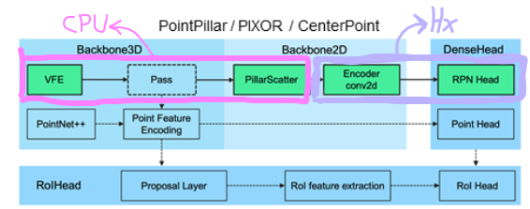

# Setup

## Install, imports, names
``` 
For the notebook to run properly, please first:

1. Install CUDA and Pytorch. Tested configs:
    a.) torch=1.12.1+cu113 (CUDA 11.3)
    b.) torch=1.12.1+cu102 (CUDA 10.2)
2. Clone & install OpenPCDet: (also consult repo instructions)
   pip install -r requirements
   pip install spconv kornia
   python setup.py develop
   (tested w. commit a68aaa656 04-Apr-23) 
3. Install Mayavi for 3D visualization of point clouds and 3D boxes

Download pretrained PointPillar pytorch model from the link below into <openpcdet-clone-location>:
```
[https://drive.google.com/file/d/1wMxWTpU1qUoY3DsCH31WJmvJxcjFXKlm/view?usp=sharing]

In [ ]:
import pcdet, torch
pcdet.__version__, torch.__version__

In [ ]:
"""
 (!) Make sure to install mayavi before running with visualization enabled.
     Might require installation of PyQT5/Pyside, and additional config depending on platform.
     If running on a headless (no screen) server, it might help to prepend the jupyter-notebook command with 
     an ad-hoc virtual X-server creation, s.a.:  xvfb-run --server-args="-screen 0 1024x768x24" jupyter notebook ...
"""
do_visualize = True   # switch to False to get notebook to run smooth in case of visualization setup issues

In [ ]:
import sys
openpcdet_clonedir = '/local/users/alexf/OpenPCDet'
sys.path.append(openpcdet_clonedir+'/tools/')

In [ ]:
import argparse
import glob
from pathlib import Path
import inspect

import numpy as np
import torch
import spconv

from pcdet.config import cfg, cfg_from_yaml_file
from pcdet.datasets import DatasetTemplate
from pcdet.models import build_network, load_data_to_gpu
from pcdet.utils import common_utils

In [ ]:
if do_visualize: 
    import mayavi.mlab as mlab
    from visual_utils import visualize_utils as V    
    mlab.init_notebook(backend='png')
    mlab.figure()  # test to fail early on mayavi setup issue if any..

In [ ]:
import os
from importlib import reload
import openpcdet2hailo_utils as ohu; reload(ohu)

def get_model(cfg, pth_name, demo_dataset):    
    model = build_network(model_cfg=cfg.MODEL, num_class=len(cfg.CLASS_NAMES), dataset=demo_dataset)
    model.load_params_from_file(filename=pth_name, logger=logger, to_cpu=True)
    model.eval()
    return model

In [ ]:
pth_name = openpcdet_clonedir+'/pointpillar_7728.pth'  
# Downloaded from [https://drive.google.com/file/d/1wMxWTpU1qUoY3DsCH31WJmvJxcjFXKlm/view?usp=sharing]

demo_pointcloud = './000102.bin'
yaml_name = openpcdet_clonedir+'/tools/cfgs/kitti_models/pointpillar.yaml'

har_name = 'pp_bev_w_head.har'
hef_name = har_name.replace('.har', '.hef')
logger = common_utils.create_logger()

In [ ]:
def cfg_from_yaml_file_wrap(yaml_name, cfg):
    cwd = os.getcwd()
    os.chdir(openpcdet_clonedir+'/tools/')
    cfg_from_yaml_file(yaml_name, cfg)
    os.chdir(cwd)

## Sanity-test: reproduce original OpenPCdet minimalistic demo 

```  
Code based on tools/demo.py as provided by original repo, tweaked a bit to reduce GPU usage to bare minimum.
```

In [ ]:
logger.info('------ Quick Demo of OpenPCDet''s PointPillars -------')
cfg_from_yaml_file_wrap(yaml_name, cfg)
display(cfg.DATA_CONFIG)

demo_dataset = ohu.DemoDataset(
    dataset_cfg=cfg.DATA_CONFIG, class_names=cfg.CLASS_NAMES, training=False,
    root_path=Path(demo_pointcloud), ext='.bin', logger=logger
)
logger.info(f'Total number of samples: \t{len(demo_dataset)}')

model = get_model(cfg, pth_name, demo_dataset)
model_cpu = ohu.PointPillarsCPU(model)

with torch.no_grad():
    for idx, data_dict in enumerate(demo_dataset):        
        data_dict = demo_dataset.collate_batch([data_dict])
        pred_dicts, _ = model_cpu(data_dict)
        # print(pred_dicts)
        break

In [ ]:
if do_visualize: 
    fig = mlab.figure(size=(1920, 1080))            
    s = ohu.my_draw_scenes(fig=fig, V=V,
            points=data_dict['points'][:, 1:].cpu().numpy(), #        
            ref_boxes=pred_dicts[0]['pred_boxes'].cpu().numpy(),
            ref_scores=pred_dicts[0]['pred_scores'].cpu().numpy(), ref_labels=pred_dicts[0]['pred_labels'].cpu().numpy()
        )
    # We visualize cloud overlayed by 3d boxes in a couple perspectives - *roughly* bev and front.
    draw_bev = True
    draw_front = True
    if draw_bev:
        mlab.view(azimuth=0, elevation=0, distance=30, focalpoint=(15,0,8))   #  ~ BEV
        mlab.savefig('orig_model_bev.png', figure=fig) 
    if draw_front:
        mlab.view(azimuth=-179, elevation=70, distance=25, focalpoint=(5,0,5)) #  ~ front ..
        mlab.savefig('orig_model_front.png', figure=fig)
else:
    print(pred_dicts)  # not very readable, visualization is better:)

In [ ]:
import IPython
width = 480  # use x4 (1920) for a full HD image
IPython.display.Image('./orig_model_front.png', width=width)

## Dissect the 2D parts and export to ONNX so we can parse for Hailo

```
We re-frame as pytorch module with tensor (not dictionary) I/O, starting from spatial_features and ending just before generate_boxes()  (so technically we don't map ALL of the dense-head, skipping the box generation; this can be remedied later with more semi-manual work representing via hailo-compatible ops, with anchors encoded as weights, etc etc.) 

```

In [ ]:
""" Check out Bev_w_Head code in openpcdet2hailo_utils.py.
    It's a slight rewrite of a section of the forward() method of openpcdet's pointpillars module, 
     desribing roughly the "backbone_2d" and "dense_head" parts. 
    Instead of using the common dictionary, it accepts the relevant tensor ("spatial_features") directly (vs. dictionary).
    Wraps the original module which it accepts in constructor, code is copied from orig forward().
"""
reload(ohu)    
bev_w_head = ohu.Bev_w_Head(model.backbone_2d, model.dense_head)
export_res = torch.onnx.export(bev_w_head, args=(data_dict['spatial_features'],), 
                               f="pp_bev_w_head.onnx", verbose=False)

In [ ]:
#!onnxsim pointpillars_backbone2d.onnx pointpillars_backbone2d_simplified.onnx
!onnxsim pp_bev_w_head.onnx pp_bev_w_head_simple.onnx

## Translate into Hailo internal representation

In [ ]:
import numpy as np
import onnxruntime
from hailo_sdk_client import ClientRunner
from hailo_sdk_common.targets.inference_targets import SdkNative
from hailo_sdk_client import InferenceContext #SdkPartialNumeric, SdkNative # 
import tensorflow as tf
import hailo_sdk_client, hailo_sdk_common
print(hailo_sdk_client.__version__)

In [ ]:
runner = ClientRunner(hw_arch='hailo8')
onnx_path = "pp_bev_w_head_simple.onnx"
hn, npz = runner.translate_onnx_model(onnx_path)
runner.save_har(har_name)

## Verify inference equivalence with Hailo emulation injected into Pytorch

```
The HAR encapsulates the 2D part of the model, and we'd like to emulate it's execution by Hailo, as a part of the overall model. For that we'll be integrating via an alternate Pytorch model such that the 2D modules are replaced by a call into Hailo emulator executing the operations described by the HAR. To this end, we first create a torch submodule which executes hailo emulator, and can replace a section of the full torch model.
```

In [ ]:
class Bev_W_Head_Hailo(torch.nn.Module):
    """ Drop-in replacement to the sequence of original "backbone-2d" and "dense_head" modules, accepting and returning dictionary,
        while under the hood using Hailo [emulator] implementation for the 2D CNN part, accepting and returning tensors I/O
    """
    def __init__(self, runner, emulate_quantized=False, use_hw=False, generate_predicted_boxes=None):
        super().__init__()
        self._runner = runner
        self.generate_predicted_boxes = generate_predicted_boxes
        
        if use_hw:
            context_type = InferenceContext.SDK_HAILO_HW
        elif emulate_quantized:
            context_type = InferenceContext.SDK_QUANTIZED 
        else:
            context_type = InferenceContext.SDK_FP_OPTIMIZED
            
        with runner.infer_context(context_type) as ctx:
            self._hailo_model = runner.get_keras_model(ctx)   
            
    def forward(self, data_dict):        
        spatial_features = data_dict['spatial_features']
        
        spatial_features_hailoinp = np.transpose(spatial_features.cpu().detach().numpy(), (0,2,3,1))
        
        # ============ Hailo-emulation of the Hailo-mapped part ==========
        spatial_features_2d, cls_preds, box_preds, dir_cls_preds = \
                            self._hailo_model(spatial_features_hailoinp)
        # ================================================================
        
        print('goo')
        print(cls_preds.shape, type(cls_preds), box_preds.shape)
        cls_preds = torch.Tensor(cls_preds.numpy()) # .permute(0, 2, 3, 1).contiguous()          # [N, H, W, C]
        box_preds = torch.Tensor(box_preds.numpy()) # .permute(0, 2, 3, 1).contiguous()          # [N, H, W, C]
        dir_cls_preds = torch.Tensor(dir_cls_preds.numpy()) # .permute(0, 2, 3, 1).contiguous()
                
        data_dict['spatial_features_2d'] = torch.Tensor(spatial_features_2d.numpy())
        
        batch_cls_preds, batch_box_preds = self.generate_predicted_boxes(
            batch_size=data_dict['batch_size'],
            cls_preds=cls_preds, box_preds=box_preds, dir_cls_preds=dir_cls_preds
        )
        data_dict['batch_cls_preds'] = batch_cls_preds
        data_dict['batch_box_preds'] = batch_box_preds
        data_dict['cls_preds_normalized'] = False

        return data_dict


```
We'll test to verify predictions with offload to Hailo emulator similar to the original - 
 that shows a successful parsing and full-precision emulation
```

In [ ]:
def quick_test(runner, hailoize=True, emulate_quantized=False, use_hw=False, fname='000102.bin', verbose=False):
    """ Encapsulates a minimalistic test of the complete network with/without hailo offload emulation 
    """
    demo_dataset = ohu.DemoDataset(
        dataset_cfg=cfg.DATA_CONFIG, class_names=cfg.CLASS_NAMES, training=False,
        root_path=Path(fname), ext='.bin', logger=logger
    )
    logger.info(f'Total number of samples: \t{len(demo_dataset)}')
    
    model_h = build_network(model_cfg=cfg.MODEL, num_class=len(cfg.CLASS_NAMES), dataset=demo_dataset)
    model_h.load_params_from_file(filename=pth_name, logger=logger, to_cpu=True)
    model_h.eval()

    #bb2d_hailo1 = BB2d_Hailo(runner, pppost_onnx='./pp_tmp_post.onnx', emulate_quantized=emulate_quantized, use_hw=use_hw)
    bev_w_head_hailo = Bev_W_Head_Hailo(runner, generate_predicted_boxes=model_h.dense_head.generate_predicted_boxes,
                                        emulate_quantized=emulate_quantized, use_hw=use_hw)    
    
    if hailoize:        
        # ==== Hook a call into Hailo by replacing parts of sequence by our rigged submodule ====
        model_h.module_list = model_h.module_list[:2] + [bev_w_head_hailo]
        # =======================================================================================                                          
    
    model_cpu = ohu.PointPillarsCPU(model_h) 
    logger.info(f'Total number of samples: \t{len(demo_dataset)}')

    for idx, data_dict in enumerate(demo_dataset):
        logger.info(f'Visualized sample index: \t{idx + 1}')
        data_dict = demo_dataset.collate_batch([data_dict])            
        pred_dicts, _ = model_cpu.forward(data_dict)
        if verbose:
            print(pred_dicts)
        else:
            print(pred_dicts[0]['pred_scores'][:7])
            
quick_test(runner, hailoize=False, emulate_quantized=False)     
quick_test(runner, hailoize=True, emulate_quantized=False)     
# This should give exact same result as we're yet to actually emulate the HW datapath,
#   with its "lossy-compression" (e.g., 8b) features. 
# This will be possible after calibration and quantization of the model which will also enabling compilation for a physical HW.


# Optimize & compile for Hailo HW

## Make HW-compatible numeric model (q-HAR) 
```
 Model Optimization aka Quantization
```

### Create the input calibration dataset for the backbone_2d in numpy format 
```
by collecting the spatial_features inputs to backbone_2d, over several point clouds
```

In [ ]:
# TODO - provide download of at least 8 point clouds

cfg_from_yaml_file_wrap(yaml_name, cfg)
demo_dataset = ohu.DemoDataset(
    dataset_cfg=cfg.DATA_CONFIG, class_names=cfg.CLASS_NAMES, training=False,
    root_path=Path(openpcdet_clonedir+'/data/kitti/testing/velodyne_reduced'), ext='.bin', logger=logger
)
logger.info(f'Total number of samples: \t{len(demo_dataset)}')
model = build_network(model_cfg=cfg.MODEL, num_class=len(cfg.CLASS_NAMES), dataset=demo_dataset)
model.load_params_from_file(filename=pth_name, logger=logger, to_cpu=True)
model.cuda()
model.eval()
cs_size = 8
calib_set = np.zeros((cs_size, 496, 432, 64))
np.set_printoptions(precision=2)

with torch.no_grad():
    for idx, _data_dict in enumerate(demo_dataset):        
        print(f"cloud #{idx}")
        if idx >= cs_size:
            break
        _data_dict = demo_dataset.collate_batch([_data_dict])
        load_data_to_gpu(_data_dict)
        pred_dicts, goo = model.forward(_data_dict)       
        calib_set[idx] = np.transpose(_data_dict['spatial_features'].cpu().numpy(), (0,2,3,1))
        # Basic stats just to verify there's some data diversity (just in top percentile apparently...)
        print('basic stats - percentile [50, 90, 98.6, 99.7, 99.9] of data (@ 2d-net input)', \
                  np.percentile((np.abs(calib_set[idx])), [50, 90, 97, 99, 99.7, 99.9]))
    

In [ ]:
# Data is sparse, roughly ~ 99% zeros. But our quantization doesn't seem to be affected.
np.save('calib.npy', calib_set)

### Run the model optimization

In [ ]:
%%time
do_optimize = True
q_har_name = har_name.replace('.har', '.q.har')

if do_optimize:
    runner.optimize(calib_set)
    runner.save_har(q_har_name)
else:
    runner = ClientRunner(har_path=q_har_name)

### More emulation testing - now with the quantized model, closely following the numerics of the hardware
```
 Hopefully, we see here results with small-ish differences
```

In [ ]:
quick_test(runner, hailoize=False)

In [ ]:
quick_test(runner, hailoize=True, emulate_quantized=True)

# Hopefully, we see here results with small-ish differences

## Make optimal physical allocation and build the binary (HEF)

In [ ]:
%%time

do_compile = True
if do_compile:
    alls_line1 = 'shortcut_concat1_conv20 = shortcut(concat1, conv20)\n'
    open('helper.alls','w').write(alls_line1)  #   !!!!
    runner.load_model_script('./helper.alls') 

    compiled_model=runner.compile()    
    open(hef_name, 'wb').write(compiled_model)

# Expected results:
# [info] | Cluster   | Control Utilization | Compute Utilization | Memory Utilization |
# [info] +-----------+---------------------+---------------------+--------------------+
#                                        ...
# [info] +-----------+---------------------+---------------------+--------------------+
# [info] | Total     | 62.5%               | 63.7%               | 37.2%              |

# Running end2end with 2D part offloaded to Hailo HW

```
We will be using HailoRT asynchronous send/receive to demonstrate readiness for a fully pipelined processing.

Therefore, we integrate the Torch and Hailo parts differently from what we did for the emulation testing. We rip off some code from original forward() to build two torch models which encapsulate everything that happens before and after the module offloaded to Hailo.  See the code for 'PP_Pre_Bev_w_Head', 'PP_Post_Bev_w_Head' classes in the accompanying utils file.
```

In [ ]:
reload(ohu);  # PP_Pre_Bev_w_Head, PP_Post_Bev_w_Head, 

In [ ]:
""" ================================================
    Standard wrapping of HailoRT API with send/receive processes, 
    similar to other Hailo examples (or HailoRT tutorial)
    ================================================
"""

from multiprocessing import Process, Queue
from hailo_platform import (HEF, PcieDevice, VDevice, HailoStreamInterface, ConfigureParams,
 InputVStreamParams, OutputVStreamParams, InputVStreams, OutputVStreams, FormatType)

def send_from_queue(configured_network, read_q, num_images, start_time):
    """ Bridging a queue into Hailo platform FEED. To be run as a separate process. 
        Reads (preprocessed) images from a given queue, and sends them serially to Hailo platform.        
    """    
    configured_network.wait_for_activation(1000)
    vstreams_params = InputVStreamParams.make(configured_network, quantized=False, format_type=FormatType.FLOAT32)
    print('Starting sending input images to HW inference...\n')
    with InputVStreams(configured_network, vstreams_params) as vstreams:
        vstream_to_buffer = {vstream: np.ndarray([1] + list(vstream.shape), dtype=vstream.dtype) for vstream in vstreams}
        for i in range(num_images):
            hailo_inp = read_q.get()
            for vstream, _ in vstream_to_buffer.items():                                
                vstream.send(hailo_inp)
            print(f'sent img #{i}')
    print(F'Finished send after {(time.time()-start_time) :.1f}')
    return 0

def recv_to_queue(configured_network, write_q, num_images, start_time):
    """ Bridging Hailo platform OUTPUT into a queue. To be run as a separate process. 
        Reads output data from Hailo platform and sends them serially to a given queue.
    """
    configured_network.wait_for_activation(1000)
    vstreams_params = OutputVStreamParams.make_from_network_group(configured_network, quantized=False, format_type=FormatType.FLOAT32)
    print('Starting receving HW inference output..\n')
    with OutputVStreams(configured_network, vstreams_params) as vstreams:
        # print('vstreams_params', vstreams_params)
        for i in range(num_images):            
            hailo_out = {vstream.name: np.expand_dims(vstream.recv(), 0) for vstream in vstreams}                          
            write_q.put(hailo_out)
            print(f'received img #{i}')
    print(F'Finished recv after {time.time()-start_time :.1f}')
    return 0




""" ==================================
    Some final wrapping of pre and post 
    ==================================
"""

def generate_data_dicts(demo_dataset, num_images, pp_pre_bev_w_head):    
    for idx, data_dict in enumerate(demo_dataset):
        if idx > num_images :
            break                        
        data_dict = demo_dataset.collate_batch([data_dict])        
        ohu.load_data_to_CPU(data_dict)
        # ------ (!) Applying torch PRE-processing -------
        data_dict = pp_pre_bev_w_head.forward(data_dict)        
        # ------------------------------------------------
        logger.info(f'preprocessed sample #{idx}')
        yield data_dict
        
def generate_hailo_inputs(demo_dataset, num_images, pp_pre_bev_w_head):
    """ generator-style encapsulation for preprocessing inputs for Hailo HW feed
    """
    for data_dict in generate_data_dicts(demo_dataset, num_images, pp_pre_bev_w_head):
        spatial_features = data_dict['spatial_features']
        spatial_features_hailoinp = np.transpose(spatial_features.cpu().detach().numpy(), (0,2,3,1))        
        yield data_dict, spatial_features_hailoinp

def post_proc_from_queue(recv_queue, num_images, pp_post_bev_w_head,
                         output_layers_order = ['model/concat1', 'model/conv18', 'model/conv19', 'model/conv20']):
    results = []
    for i in range(num_images):
        print('a')
        t_ = time.time()                
        while(recv_queue.empty() and time.time()-t_ <3):                    
            time.sleep(0.01)
        if recv_queue.empty():
            print("RECEIVE TIMEOUT!")
            break
        hailo_out = recv_queue.get(0)   
        if False:
            for k, ho in hailo_out.items():
                print(k, "ho.shape", ho.shape)

        bev_out = (hailo_out[lname] for lname in output_layers_order)        
        
        # ------ (!) Applying torch POST-processing -------
        pred_dicts, _ = pp_post_bev_w_head(bev_out)
        # ------------------------------------------------
        results.append(pred_dicts)
        # print(pred_dicts[0]['pred_scores'])  
    return results

In [ ]:
import time, onnxruntime

data_source = demo_pointcloud  # replace by a folder for a more serious test
num_images = 1

cfg_from_yaml_file_wrap(yaml_name, cfg)
logger = common_utils.create_logger()
demo_dataset = ohu.DemoDataset(
    dataset_cfg=cfg.DATA_CONFIG, class_names=cfg.CLASS_NAMES, training=False,
    root_path=Path(data_source), ext='.bin', logger=logger
    )
model = get_model(cfg, pth_name, demo_dataset)

# Library creates the anchors in cuda by defalt (applying .cuda() in internal implementation)
model.dense_head.anchors = [anc.cpu() for anc in model.dense_head.anchors]

""" (!) Slicing off the torch model all that happens before and after Hailo
"""
pp_pre_bev_w_head = ohu.PP_Pre_Bev_w_Head(model)
pp_post_bev_w_head = ohu.PP_Post_Bev_w_Head(model)
    
with VDevice() as target:
    hef = HEF(hef_name)
    configure_params = ConfigureParams.create_from_hef(hef, interface=HailoStreamInterface.PCIe)
    network_group = target.configure(hef, configure_params)[0]
    network_group_params = network_group.create_params()
    recv_queue = Queue()
    send_queue = Queue()            
    start_time = time.time()
    results = []
    hw_send_process = Process(target=send_from_queue, args=(network_group, send_queue, num_images, start_time))
    hw_recv_process = Process(target=recv_to_queue, args=(network_group, recv_queue, num_images, start_time))            
    
    with network_group.activate(network_group_params): 
        hw_recv_process.start()        
        hw_send_process.start()

        # Note: still short of 'infinitely streamed' demo as neither (A) nor (B) can offload to a separate process 
        #       because of unfortunate cuda issues with multiproc (cuda not used in (A) but still loaded).
        # One partial solution could be to intermittently feed-in/process-out according to queues status, keeping HW busy
        
        # (A)
        for data_dict, hailo_inp in generate_hailo_inputs(demo_dataset, num_images, pp_pre_bev_w_head):
            send_queue.put(hailo_inp)                    

        # (B)
        results = post_proc_from_queue(recv_queue, num_images, pp_post_bev_w_head)
                             
hw_recv_process.join(10)
hw_send_process.join(10)

pred_dicts = results[-1]
print(pred_dicts[0]['pred_scores'])   

In [ ]:
if do_visualize: 
    fig = mlab.figure(size=(1920, 1080))

    s = ohu.my_draw_scenes(fig=fig, V=V,
            points=data_dict['points'][:, 1:].detach(),       
            ref_boxes=pred_dicts[0]['pred_boxes'].detach(),
            ref_scores=pred_dicts[0]['pred_scores'].detach(), ref_labels=pred_dicts[0]['pred_labels'].detach()
        )
    
    draw_bev = True
    draw_front = True
    if draw_bev:
        mlab.view(azimuth=0, elevation=0, distance=30, focalpoint=(15,0,8))   #  ~ BEV
        mlab.savefig('hailo_assisted_model_bev.png', figure=fig) 
    if draw_front:
        mlab.view(azimuth=-179, elevation=70, distance=25, focalpoint=(5,0,5)) #  ~ front ..
        mlab.savefig('hailo_assisted_model_front.png', figure=fig)
    

In [ ]:
import IPython
width = 480  # use x4 (1920) for a full HD image
IPython.display.Image('./hailo_assisted_model_front.png', width=width)

# Appendix A:   OpenPCDet integration details

```
Here we explain how we arrived at the openpcdet-hailo integration details that might have appeared as "magic" in the code above and in the integration-utils module - which is by and large simply pieces of opencpcdet code copied and modified in specific ways to make integration convenient. For example, how to isolate the torch subgraph to translate to Hailo, patch the inference func with a call into Hailo emulator/hardware, etc.
```

**This might be useful in case you want to integrate and Hailo-offload a NEW OpenPCDet model**

**In that case, you might want to repeat the exploration steps below and modify the integration code accordingly.**

```
NOTE: apart from inspecting tensor structure on model_cpu object (that we assume to have been run during "sanity test" above), we will also be just statically eyeballing some openpcdet code via python's "inspecting". This might look cumbersome, and sure you can just browse the repo. However, from our experience, the "inspect" approach is not only convenient for display in notebook, but actually useful to quickly get to the code that **actually gets to run**, bypassing all configuration switches which might be rather complex in big modular 'many-model' repos.
```

## Explore model structure

In [ ]:
import inspect
print(inspect.getsource(model.forward))

In [ ]:
model.module_list[0] == model.vfe, model.module_list[1] == model.map_to_bev_module, \
  model.module_list[2] == model.backbone_2d, model.module_list[3] == model.dense_head

```
From this we learn that model is a sequence of 4 modules.
We want to offload the model.module_list[2] == model.backbone_2d ,
along with model.module_list[3] == model.dense_head.

Now let's take apart the modules and their forward() and I/O:
```

In [ ]:
for submodule in model.module_list:
    print('='*50)
    print(submodule)
    print(inspect.getsource(submodule.forward))


``` 
Also let's take a look at shapes of all intermediate results
```

In [ ]:
pred_dicts, _ = model_cpu.forward(data_dict)
# NOTE: now data_dict has been populated with all intermediate results, as a side-effect

for k,v in data_dict.items():
    try: 
        print(k, v.shape) #, np.max(np.abs(v.cpu().numpy())))
    except:
        print(k, v)

```
From this we learn that input to 2d-backbone part is the "spatial_features" key,
   tensor shaped as torch.Size([1, 64, 496, 432]

And the output from the "dense" head module is 'batch_cls_preds' and 'batch_box_preds' keys.

Let's explore the last non-neural part of the dense_head - box decoder from anchors and net results, encapsulated in generate_predicted_boxes(). This part will take some further tweaks to get mapped to Hailo, as exists for 2D detection heads (ssd, yolo, etc.).  We leave that for future work
```

In [ ]:
print(model.dense_head.conv_dir_cls)
print(inspect.getsource(model.dense_head.generate_predicted_boxes))

In [ ]:
print_backbone_2d_details = False
print_all_modules_details = False

if print_backbone_2d_details:
    print(model.backbone_2d)
if print_all_modules_details:
    for ml in model.module_list:
        print('='*50)
        print(ml)
for c in model.named_children():
    print(c)